# Short tau exercise: Part 1

Learning objectives:
* __the reconstruction of hadronic tau decays in different decay modes__ (this part)
* discrimination of hadronic tau decys against jets, electrons, and muons. (part 2)

Additional material:
* __TAU-16-003: Latest paper about tau reconstruction http://cms-results.web.cern.ch/cms-results/public-results/publications/TAU-16-003/index.html__
* DeepTau: Algorithm based on neural networks to discriminate taus against jets, muons, and electrons https://cds.cern.ch/record/2694158

In [3]:
from __future__ import print_function # retain python 2 compatibility
import ROOT
from dm_migration import dm_migration

Welcome to JupyROOT 6.20/06


The following file contains reconstructed hadronic taus matched to true hadronic tau decays, which can hence be used to study tau reconstruction.

* The files were preprocessed using the tau validation tools here https://github.com/cms-tau-pog/TauReleaseValidation
* We extract the contained TTree "per_tau" that contains one entry per generated tau. The branches for reconstructed taus This allows us to study which fraction of taus was successfully reconstructed.

In [4]:
base_dir = '/eos/user/s/steggema/public/TauExercise/'
base_dir = '/Users/jan/cernbox/public/TauExercise'
tau_sample = f'{base_dir}/ztt_10_6_14.root'
tau_file = ROOT.TFile.Open(tau_sample)
tau_tree = tau_file.Get('per_tau')

To understand better which variables are contained in the tree and how they are distributed, it can be investigated in this notebook, or by other means (e.g. a TBrowser).

_If you feel adventurous, it can be an interesting exercise to use the first few lines of code below to write a general tool that makes plots of all variables in a TTree, making some assumptions about what "undefined" means and cutting out this part of the plot_

In [1]:
# # Print all branch names
# print([g.GetName() for g in tau_tree.GetListOfBranches()])

# # Manually draw distributions of variables obtained from the following list, like one would do with a TBrowser
# cv = ROOT.TCanvas()
# tau_tree.Draw('tau_pt')
# cv.Draw()
# tau_tree.Draw('tau_pt', 'tau_pt > 0.') # only draw if tau was actually reconstructed
# cv.Draw()

# # Use some more magic to extract useful variable ranges towards automating drawing distributions of variables
# import math
# import numpy as np
# vals = np.array([tau_tree.GetV1()[i] for i in range(tau_tree.GetEntries())])
# vals = vals[vals>-10]
# hist = ROOT.TH1F('tau_pt', '', 20, math.floor(np.min(vals)), math.ceil(np.max(vals)))
# tau_tree.Project('tau_pt', 'tau_pt')
# hist.Draw()
# cv.Draw()

# # Alternatively, to inspect the file, type t = ROOT.TBrowser() in an interactive ROOT 
# # session or "rootbrowse <filename>" in a shell

How do taus actually decay? Here's a table from the TAU-16-003 paper linked above that links the different tau decay modes together with their branching fractions and whether the decay proceeds via an intermediate resonance:

![Tau decays](tau_decays.png)

In the CMS tau reconstruction, we are bothered with reconstructing hadronic tau decays only since decays to electrons/muons + neutrinos are covered by different groups and experimentally very differnt.

The CMS tau reconstruction initially focussed on three main decay modes:
* One-prong (without pi0) - 1st line in the table above under hadronic decays
* One-prong + pi0s - 2nd and 3rd lines
* Three-prong (without pi0) - 4th line

In the tau reconstruction code, we give integer values to the decay modes via the relation `dm = 1 + 3*n_charged + n_pi0`


**Let's try to investigate if we efficiently reconstruct taus.**

3296 generated taus of which 2782 are reconstructed
Efficiency: 0.844
2246 also pass the "old" decay mode finding
Efficiency: 0.681


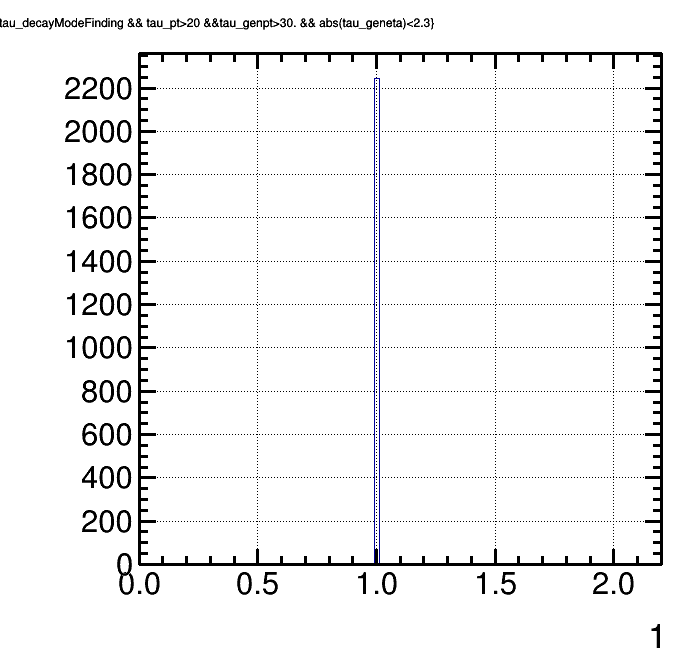

In [18]:
# We're interested in taus well within tht tracker acceptance and with minimum pT
cv = ROOT.TCanvas()
base_sel = 'tau_genpt>30. && abs(tau_geneta)<2.3'
n_all = tau_tree.Draw('1', base_sel)
n_pass = tau_tree.Draw('1', 'tau_pt>20 &&' + base_sel)
print(n_all, 'generated taus of which', n_pass, 'are reconstructed')
eff = n_pass/n_all
print(f'Efficiency: {eff:.3f}')
n_pass_and_dm = tau_tree.Draw('1', 'tau_decayModeFinding && tau_pt>20 &&' + base_sel)
print(n_pass_and_dm, 'also pass the "old" decay mode finding')
eff = n_pass_and_dm/n_all
print(f'Efficiency: {eff:.3f}')
cv.Draw()

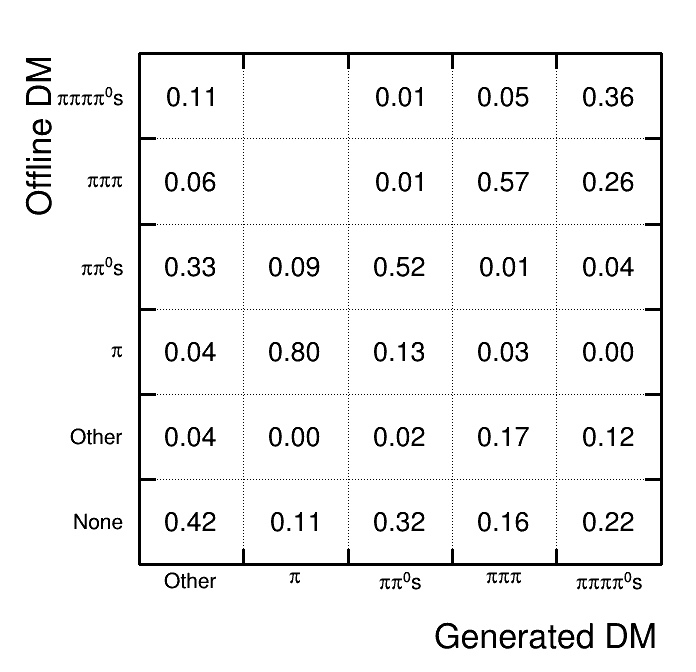

In [3]:
canvas = dm_migration(tau_tree)
canvas.Draw()

To distinguish taus and jets, different observables are helpful. Classically the most important ones are so-called isolation variables that look at the sum of the pT values of all particles in a cone around the tau axis that are not used in the tau reconstruction: Since jets have high multiplicity, the isolation values tend to be high for jets while they are small for true taus, where ideally all tau energy was used in the reconstruction of the tau candidate and the only remaining particles in a cone around the tau come from pileup or the underlying event. The simplest is the sum of the pT of all charged particles that are compatible with coming from the primary interaction vertex.